In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.random import randint
from multiprocessing import cpu_count
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluatin metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import gc
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
application_train = import_data('/content/drive/MyDrive/home-credit-default-risk/application_train.csv')
application_test = import_data('/content/drive/MyDrive/home-credit-default-risk/application_test.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


In [6]:
pd.set_option('display.max_rows', 30)
def info(table):
    print(f'\n the shape of the table is : \n',table.shape)
    print('-' * 80)
    print('\n data types : ', table.dtypes.value_counts().sort_values())
    print('-' * 80)
    missings=table.isna().mean()[table.isna().mean().sort_values(ascending=False)!=0].sort_values(ascending=False)
    print('-' * 80)
    print('\n number of features having missing data : ',len(missings))
    print('-' * 80)
    print('\n missing data in the table: \n',missings)
    print('-' * 80)
    print(missings[missings>0.5])
    print('-' * 80)
    print('\n missing data over 50% : ',len(missings[missings>0.5]))
info(application_train)


 the shape of the table is : 
 (307511, 122)
--------------------------------------------------------------------------------

 data types :  int16       2
int32       2
float32     4
object     16
int8       37
float16    61
Name: count, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 number of features having missing data :  67
--------------------------------------------------------------------------------

 missing data in the table: 
 COMMONAREA_MEDI             0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_AVG              0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHONE_CHANGE      0.000003
Length: 67, dtype: 

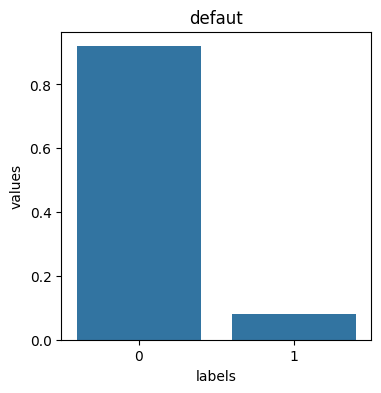

In [7]:
temp = application_train.TARGET.value_counts()
df1 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(application_train)})
plt.figure(figsize = (4,4))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

In [8]:
NUMERIC_FEATURES = application_train.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']).columns

In [9]:
application_train[NUMERIC_FEATURES].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.0,265992.0,265992.0
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990259e+05,27108.572266,5.383961e+05,0.000000,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.000000,0.000000,0.000000,NaN,NaN,NaN
std,102790.175348,0.272419,0.722121,2.371759e+05,4.024795e+05,14493.233398,3.695427e+05,0.013824,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083984,0.110718,0.204712,0.0,0.0,0.0
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010010,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018845,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028656,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.0
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072510,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.0,261.0,25.0


In [10]:
def plot_distribution(df, FEATURES):
    i = 0
    t1 = df.loc[df['TARGET'] != 0]
    t0 = df.loc[df['TARGET'] == 0]

    sns.set_style('whitegrid')
    fig, ax = plt.subplots(4, 2, figsize=(16, 20))

    for feature in FEATURES:
        if feature != 'TARGET':
            i += 1
            plt.subplot(4, 2, i)
            sns.kdeplot(t1[feature], bw=0.5, color='red', label="TARGET = 1")
            sns.kdeplot(t0[feature], bw=0.5, label="default = 0")
            plt.ylabel('Density plot', fontsize=12)
            plt.xlabel(feature, fontsize=12)
            plt.xticks(fontsize=12, rotation=90)  # Set the font size for x-axis labels
            plt.yticks(fontsize=12)  # Set the font size for y-axis labels

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

In [11]:
domain_features=['AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE']

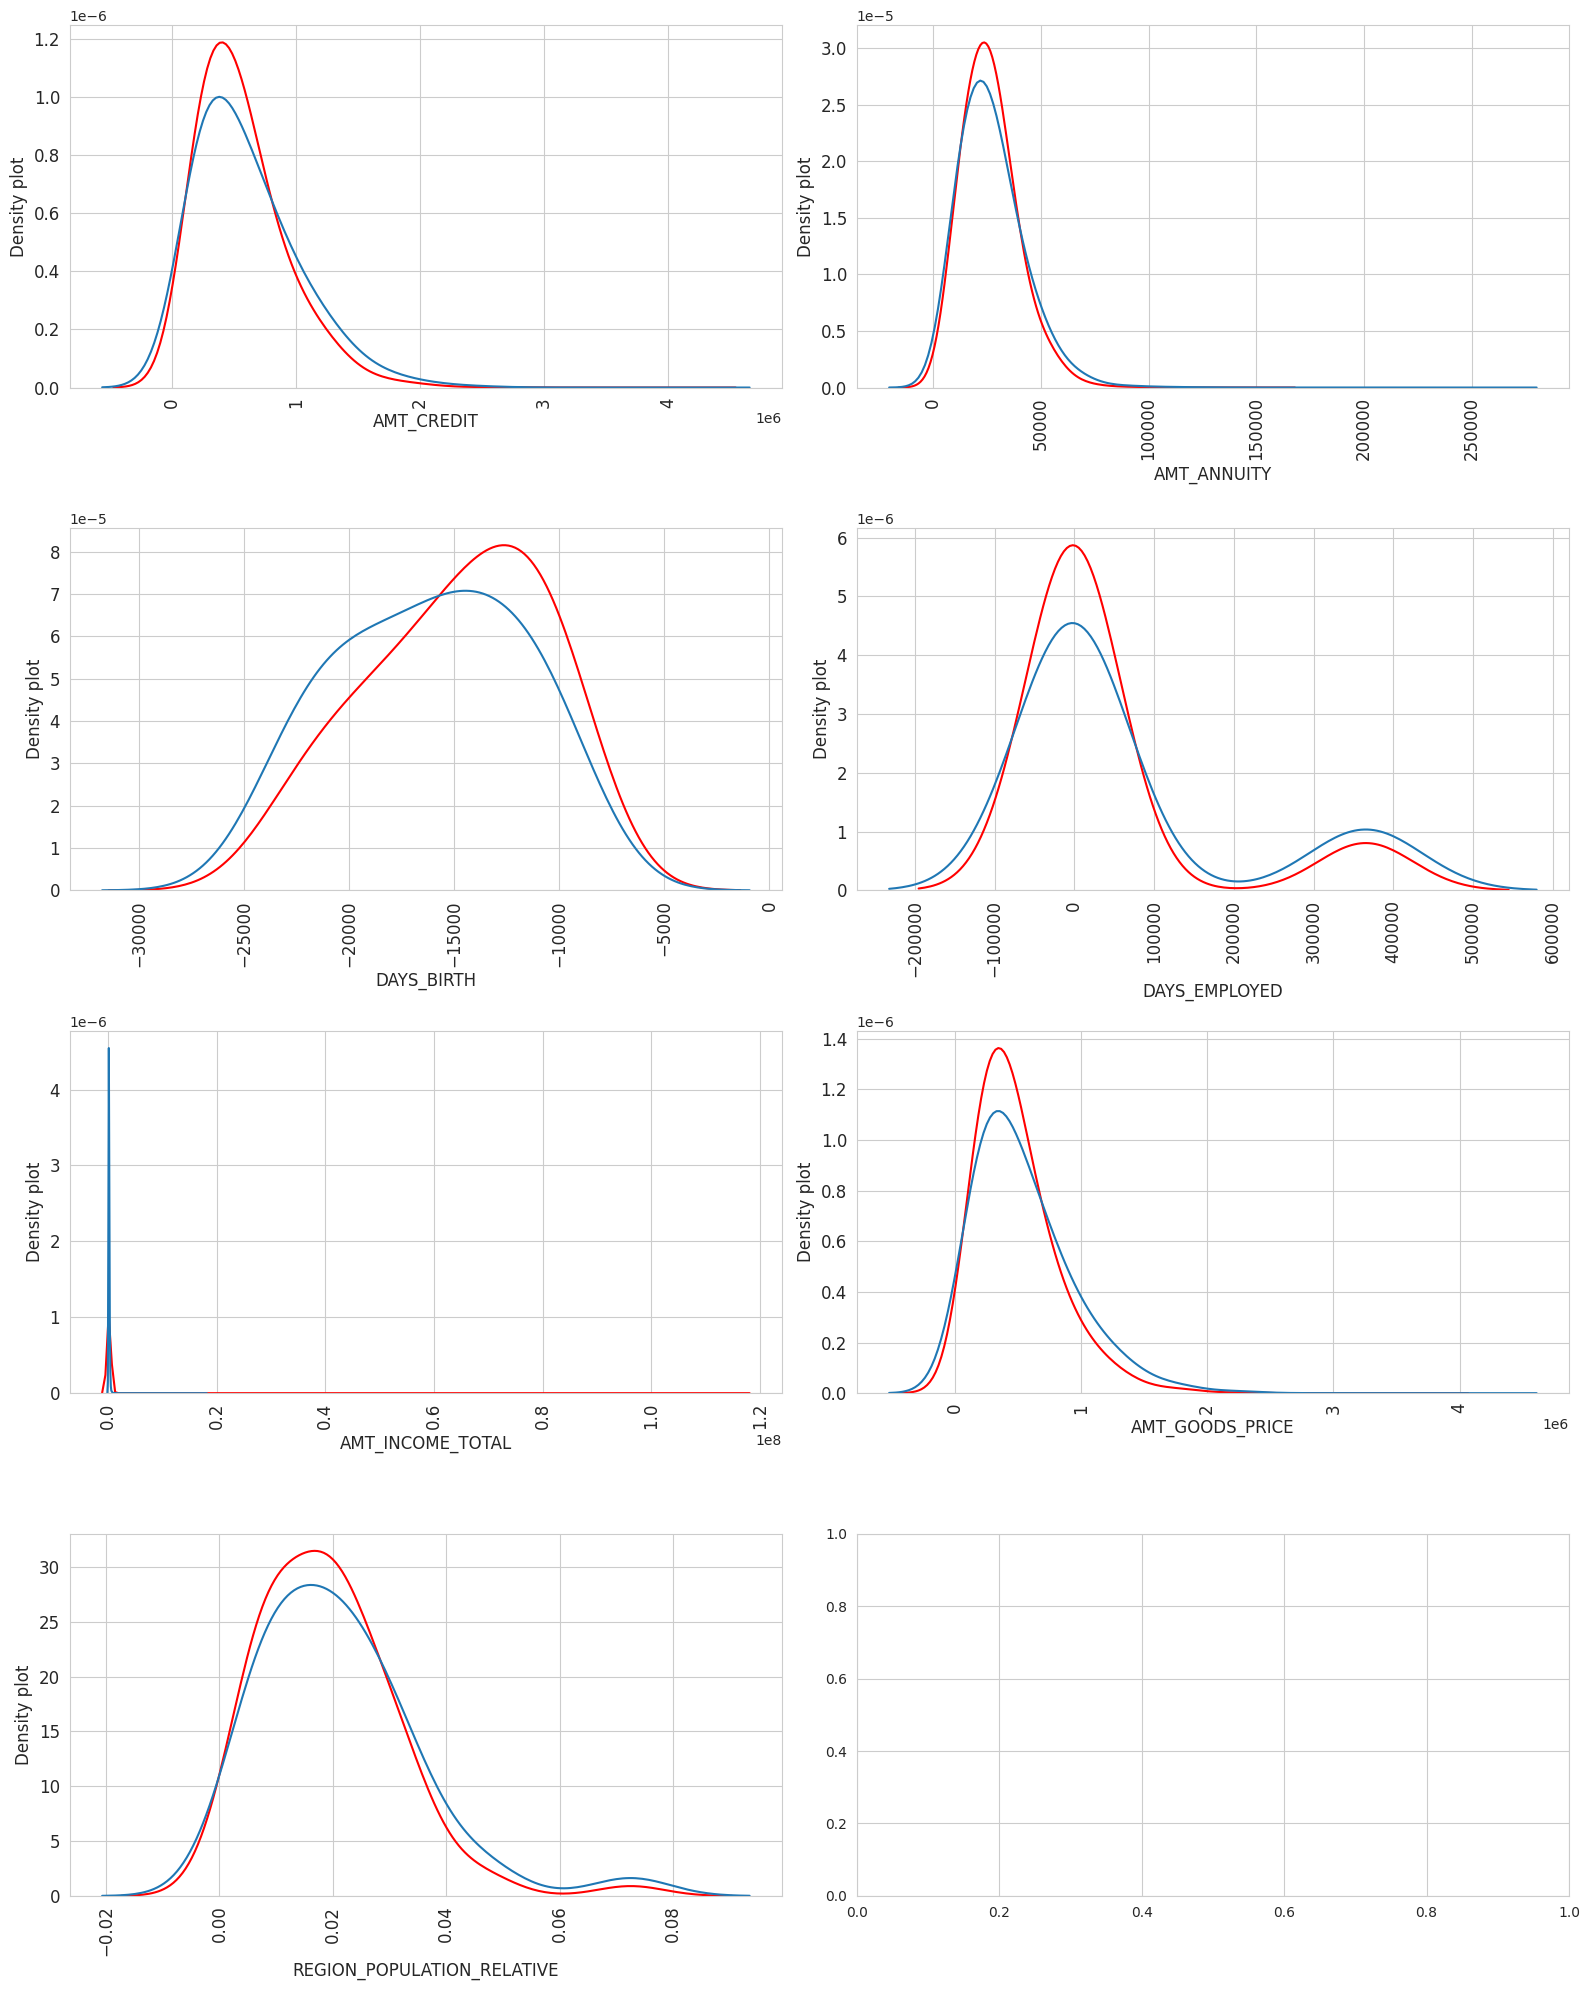

In [12]:
plot_distribution(application_train,domain_features)

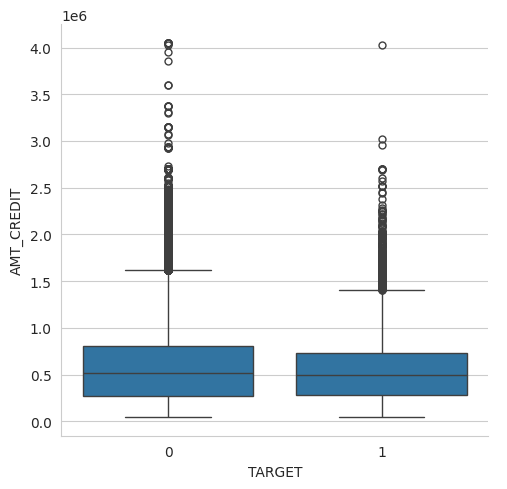

In [13]:
sns.catplot(application_train.drop(application_train.AMT_INCOME_TOTAL.argmax())
,x='TARGET',y='AMT_CREDIT',kind='box');

In [14]:
def t_test(df):
    t_stat_list=[]
    p_val_list=[]
    variable=[]

    for var in df.columns:
        t_stat, p_val = stats.ttest_ind(application_train[application_train['TARGET'] == 0][var],
                                        application_train[application_train['TARGET'] == 1][var])
        if p_val < 0.05:
            variable.append(var)
            t_stat_list.append(t_stat)
            p_val_list.append(p_val)

    t_test = pd.DataFrame({'variable': variable, 't_stat': t_stat_list, 'p_val': p_val_list})
    return t_test.sort_values(by='p_val',ascending=True)

In [15]:
t_test(application_train.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']))

,variable,t_stat,p_val
0,TARGET,-inf,0.000000e+00
4,DAYS_BIRTH,-43.519836,0.000000e+00
11,REGION_RATING_CLIENT_W_CITY,-33.829889,2.078455e-250
10,REGION_RATING_CLIENT,-32.718363,2.172433e-234
6,DAYS_ID_PUBLISH,-28.572653,2.527524e-179
16,REG_CITY_NOT_WORK_CITY,-28.315052,3.805463e-176
7,FLAG_EMP_PHONE,-25.525747,1.442660e-143
5,DAYS_EMPLOYED,24.941366,3.631173e-137
15,REG_CITY_NOT_LIVE_CITY,-24.643084,5.894986e-134
19,FLAG_DOCUMENT_3,-24.615815,1.153611e-133


In [16]:
application_train.select_dtypes('O').nunique().sort_values()

,0
NAME_CONTRACT_TYPE,2
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
EMERGENCYSTATE_MODE,2
HOUSETYPE_MODE,3
CODE_GENDER,3
FONDKAPREMONT_MODE,4
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6


In [17]:
def cat_stats(df, FEATURES):
    for feature in FEATURES:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['TARGET'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['TARGET'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)

        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

        sns.set_color_codes("pastel")

        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y="Percentage_Target_0", data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()

In [18]:
important_features=['CODE_GENDER','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','OCCUPATION_TYPE',
'ORGANIZATION_TYPE']

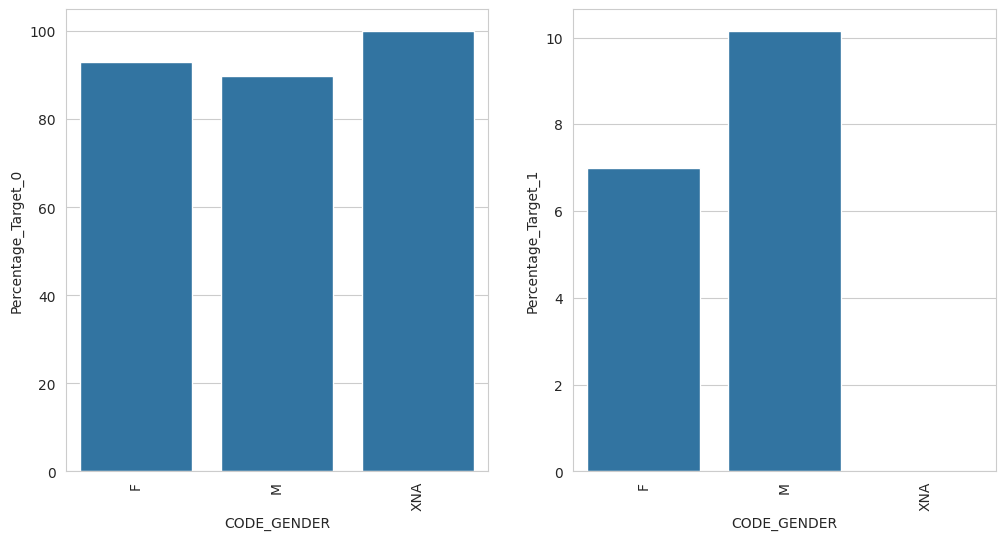

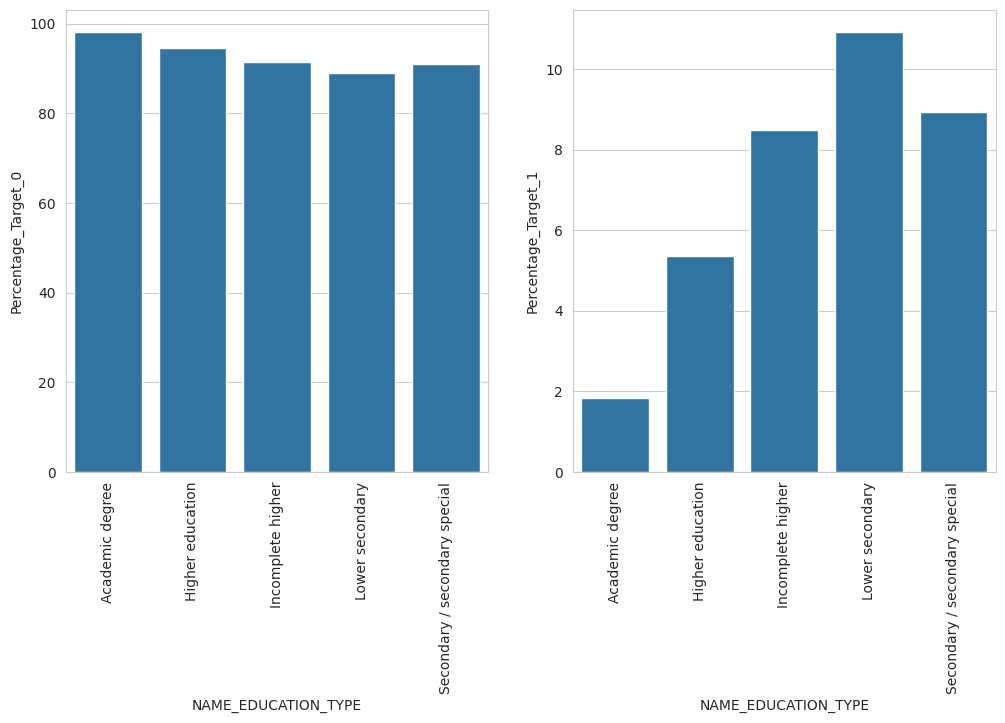

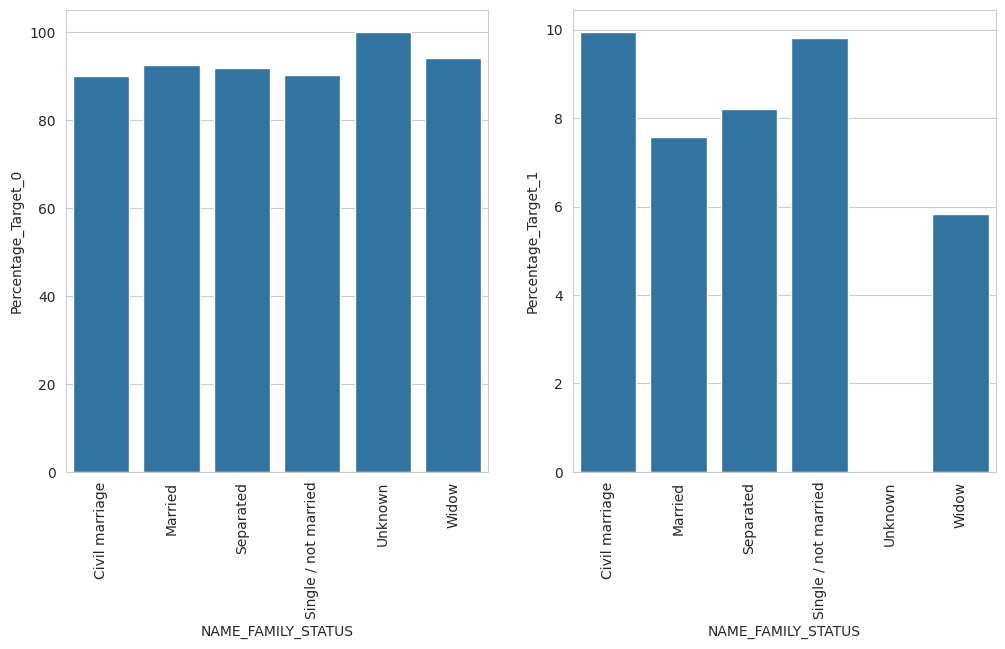

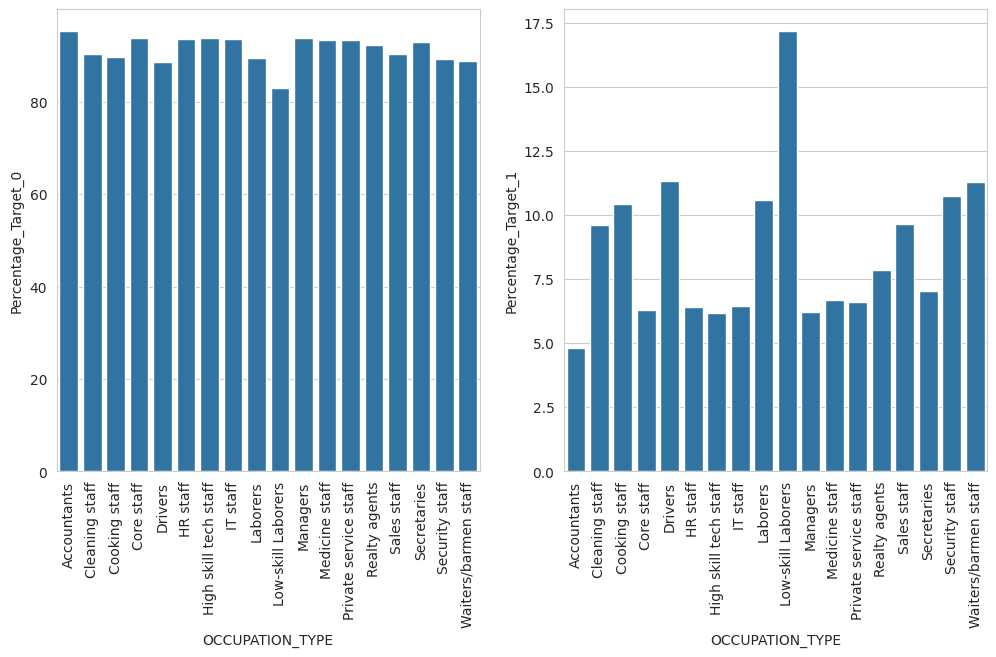

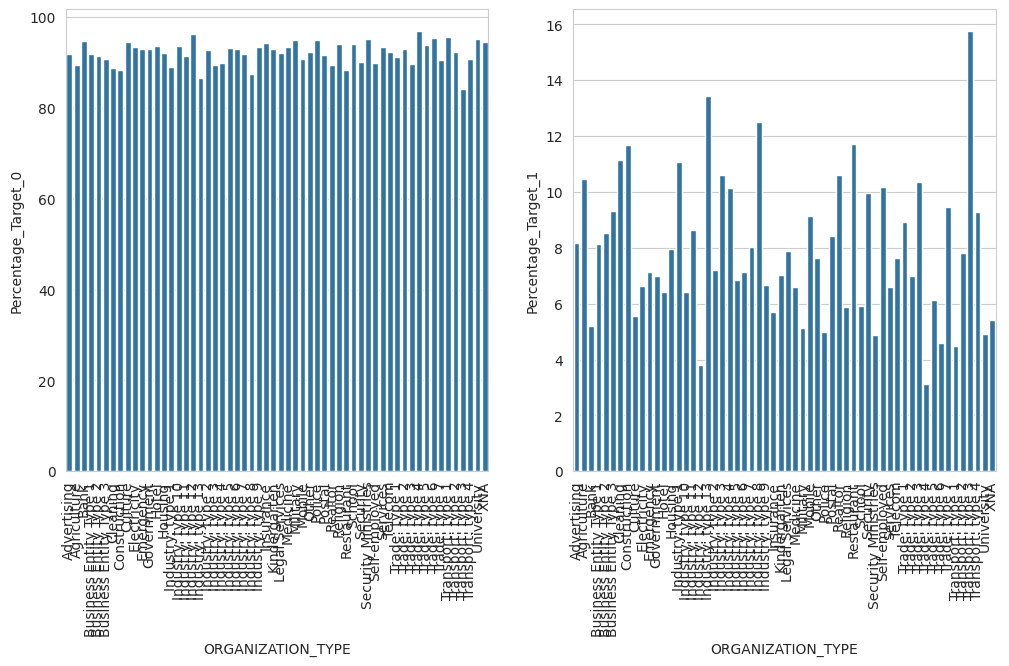

In [19]:
cat_stats(application_train,important_features)

In [20]:
# Perform chi-squared test
def chi2_test(df):
    chi2_stat_list=[]; p_val_list=[]; dof_list=[]; ex_list=[]
    for var in df.columns:
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(pd.crosstab(application_train['TARGET'], application_train[var]))
        chi2_stat_list.append(chi2_stat); p_val_list.append(p_val); dof_list.append(dof); ex_list.append(ex);
    chi_squared=pd.DataFrame({'variable':df.columns,'dof':dof_list,'chi2_stat':chi2_stat_list,'p_val':p_val_list})
    chi_squared.set_index('variable',inplace=True)
    print(chi_squared.sort_values(by='p_val',ascending=True))

In [21]:
chi2_test(application_train.select_dtypes('O'))

                            dof    chi2_stat          p_val
variable                                                   
ORGANIZATION_TYPE            57  1609.240636  5.224541e-299
OCCUPATION_TYPE              17  1402.846796  3.784500e-288
NAME_INCOME_TYPE              7  1253.470808  1.928146e-266
NAME_EDUCATION_TYPE           4  1019.213187  2.447681e-219
CODE_GENDER                   2   920.791334  1.129022e-200
NAME_FAMILY_STATUS            5   504.694083  7.744842e-107
NAME_HOUSING_TYPE             5   420.556190   1.099089e-88
NAME_CONTRACT_TYPE            1   293.150542   1.023515e-65
FLAG_OWN_CAR                  1   146.656018   9.330994e-34
WALLSMATERIAL_MODE            6   139.235314   1.453180e-27
HOUSETYPE_MODE                2    27.632556   9.992328e-07
EMERGENCYSTATE_MODE           1    23.678150   1.138680e-06
NAME_TYPE_SUITE               6    32.825315   1.132931e-05
FLAG_OWN_REALTY               1    11.575827   6.681470e-04
FONDKAPREMONT_MODE            3    16.80

In [22]:
application_train.drop('SK_ID_CURR',inplace=True,axis=1)
SK_ID_CURR=application_test['SK_ID_CURR']
application_test.drop('SK_ID_CURR',inplace=True,axis=1)
application_train['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
application_test['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
application_train['CODE_GENDER'].replace('XNA',np.nan,inplace=True)
application_test['CODE_GENDER'].replace('XNA',np.nan,inplace=True)

In [23]:
FLAG_DOCUMENT=['FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
'FLAG_DOCUMENT_21']
application_train['FLAG_DOCUMENT']=application_train[FLAG_DOCUMENT].sum(axis=1)
application_test['FLAG_DOCUMENT']=application_test[FLAG_DOCUMENT].sum(axis=1)
application_train.drop(FLAG_DOCUMENT,axis=1,inplace=True)
application_test.drop(FLAG_DOCUMENT,axis=1,inplace=True)

In [24]:
AMT_REQ_CREDIT=['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
                'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT']
application_train.drop(AMT_REQ_CREDIT,axis=1,inplace=True)
application_test.drop(AMT_REQ_CREDIT,axis=1,inplace=True)

In [25]:
# Age Feature
application_train['AGE']=application_train['DAYS_BIRTH']/(-365)
application_test['AGE']=application_test['DAYS_BIRTH']/(-365)
# MEAN_EXT_SOURCE
application_train['MEAN_EXT_SOURCE'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
application_test['MEAN_EXT_SOURCE'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# Generate YEARS_EMPLOYED
application_train['YEARS_EMPLOYED']=application_train['DAYS_EMPLOYED']/(-365)
application_test['YEARS_EMPLOYED']=application_test['DAYS_EMPLOYED']/(-365)
# DAYS_BIRTH_SQUARED
application_train['DAYS_BIRTH_SQUARED'] = application_train['DAYS_BIRTH'] ** 2
application_test['DAYS_BIRTH_SQUARED'] = application_test['DAYS_BIRTH'] ** 2
# Generate DEBT_TO_INCOME_RATIO
application_train['DEBT_TO_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_test['DEBT_TO_INCOME_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_INCOME_TOTAL']
# Generate INCOME_TO_CREDIT
application_train['INCOME_TO_CREDIT'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']
application_test['INCOME_TO_CREDIT'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_CREDIT']

In [26]:
new_numeric_features=['AGE','YEARS_EMPLOYED','DEBT_TO_INCOME_RATIO','INCOME_TO_CREDIT','DAYS_BIRTH_SQUARED']

In [27]:
t_test(application_train[new_numeric_features])

,variable,t_stat,p_val
0,AGE,43.519836,0.000000
1,DEBT_TO_INCOME_RATIO,4.284920,0.000018


In [28]:
application_train['_INCOME_CLASS']=pd.qcut(application_train['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_train['ANNUITY_CLASS']=pd.qcut(application_train['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
application_train['AMT_GOODS_PRICE_0.2_0.7']=np.where((application_train['AMT_GOODS_PRICE']<= 70000) & (application_train['AMT_GOODS_PRICE']>=20000) ,1,0)
application_train['DAYS_BIRTH_CLASS']=np.where(application_train['DAYS_BIRTH']<-15000,1,0)
application_train['CREDIT_UNDER_100K']=np.where(application_train['AMT_CREDIT']<100000,1,0)
application_train['YEARS_EMPLOYED_CLASS']=np.where(application_train['DAYS_EMPLOYED']<100000,1,0)

application_test['_INCOME_CLASS']=pd.qcut(application_test['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_test['ANNUITY_CLASS']=pd.qcut(application_test['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
application_test['AMT_GOODS_PRICE_0.2_0.7']=np.where((application_test['AMT_GOODS_PRICE']<= 7000) & (application_test['AMT_GOODS_PRICE']>=2000) ,1,0)
application_test['DAYS_BIRTH_CLASS']=np.where(application_test['DAYS_BIRTH']<-15000,1,0)
application_test['CREDIT_UNDER_100K']=np.where(application_test['AMT_CREDIT']<100000,1,0)
application_test['YEARS_EMPLOYED_CLASS']=np.where(application_test['DAYS_EMPLOYED']<100000,1,0)

In [29]:
new_categorical_features = ['_INCOME_CLASS','YEARS_EMPLOYED_CLASS','ANNUITY_CLASS',
                            'AMT_GOODS_PRICE_0.2_0.7','DAYS_BIRTH_CLASS','CREDIT_UNDER_100K']

In [30]:
chi2_test(application_train[new_categorical_features])

                         dof    chi2_stat          p_val
variable                                                
DAYS_BIRTH_CLASS           1  1344.950176  1.927723e-294
YEARS_EMPLOYED_CLASS       1   649.888509  2.362427e-143
ANNUITY_CLASS              2   157.760399   5.530502e-35
_INCOME_CLASS              2   152.501899   7.667140e-34
CREDIT_UNDER_100K          1    53.721017   2.310781e-13
AMT_GOODS_PRICE_0.2_0.7    1    34.102392   5.228696e-09


In [31]:
# Detect highly missing numeric features
application_train_numeric= application_train.select_dtypes(include=['number'])
missings=application_train_numeric.loc[:,application_train_numeric.isna().mean() >= 0.6]
highly_missing_features = missings.columns
missings.columns

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')

In [32]:
#Remove highly missing features
application_train.drop(highly_missing_features,axis=1,inplace=True)
application_test.drop(highly_missing_features,axis=1,inplace=True)

In [33]:
target = application_train['TARGET']
features_train = application_train.drop('TARGET', axis=1)

# Impute numerical features using mean imputation
numeric_imputer = SimpleImputer(strategy='median')
numeric_features_train = features_train.select_dtypes(include='number')
imputed_numeric_features_train = numeric_imputer.fit_transform(numeric_features_train)
numeric_features_test = application_test.select_dtypes(include='number')
imputed_numeric_features_test = numeric_imputer.transform(numeric_features_test)

In [34]:
categorical_features_train = features_train.select_dtypes(include='object')
# using dummy_na=False ,we perform onehot encoding without affecting data distribution
dummy_categorical_features_train = pd.get_dummies(categorical_features_train,dummy_na=False)

# Concatenate imputed numerical and categorical features Train
imputed_features_train = pd.concat([pd.DataFrame(imputed_numeric_features_train, columns=numeric_features_train.columns),
                              dummy_categorical_features_train] ,axis=1)

# Impute categorical features Test using mode imputation and one-hot encoding

categorical_features_test = application_test.select_dtypes(include='object')
dummy_categorical_features_test = pd.get_dummies(categorical_features_test,dummy_na=False)

# Concatenate imputed numerical and categorical features
imputed_features_test = pd.concat([pd.DataFrame(imputed_numeric_features_test, columns=numeric_features_test.columns),
                              dummy_categorical_features_test],
                             axis=1)

In [35]:
imputed_features_train.drop('NAME_INCOME_TYPE_Maternity leave',axis=1,inplace=True)
imputed_features_train.drop('NAME_FAMILY_STATUS_Unknown',axis=1,inplace=True)

In [3]:
app_train = pd.read_csv("/content/drive/MyDrive/home-credit-default-risk/application_train.csv")
num_features = app_train.select_dtypes(include=[np.number]).drop(columns=["TARGET", "SK_ID_CURR"])
imputer = SimpleImputer(strategy='median')
num_features_imputed = pd.DataFrame(imputer.fit_transform(num_features), columns=num_features.columns)
num_features_imputed['CREDIT_INCOME_RATIO'] = num_features_imputed['AMT_CREDIT'] / (num_features_imputed['AMT_INCOME_TOTAL'] + 1)
num_features_imputed['ANNUITY_INCOME_RATIO'] = num_features_imputed['AMT_ANNUITY'] / (num_features_imputed['AMT_INCOME_TOTAL'] + 1)
num_features_imputed['DAYS_EMPLOYED_RATIO'] = num_features_imputed['DAYS_EMPLOYED'] / (num_features_imputed['DAYS_BIRTH'] + 1)
scaler = StandardScaler()
X = scaler.fit_transform(num_features_imputed)
y = app_train["TARGET"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

In [5]:
np.mean(y_train), np.mean(y_test)

(np.float64(0.08072908198107379), np.float64(0.08072776937710356))

In [6]:
# Обучаем логистическую регрессию
# Обучаем логистическую регрессию с весами классов и C=1.0
log_reg = LogisticRegression(
    max_iter=1000,
    C=1.0,                            # регуляризация
    class_weight={0: 1, 1: 9},       # вот сюда словарь весов классов
    solver='liblinear'
)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 9}, max_iter=1000, solver='liblinear')

In [7]:
# Предсказания
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

In [8]:
# Оценка качества модели
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")
print(classification_report(y_test, y_pred))

AUC-ROC Score: 0.7383
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     56538
           1       0.18      0.56      0.27      4965

    accuracy                           0.75     61503
   macro avg       0.56      0.67      0.56     61503
weighted avg       0.89      0.75      0.80     61503



In [10]:
feature_names = num_features_imputed.columns
weights = log_reg.coef_[0]

# Создаем таблицу с весами
coef_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
coef_df['AbsWeight'] = np.abs(coef_df['Weight'])

# Сортируем по абсолютному значению веса и выводим топ-10
coef_df_sorted = coef_df.sort_values(by='AbsWeight', ascending=False)
print(coef_df_sorted[['Feature', 'Weight']].head(10))


                 Feature    Weight
12        FLAG_EMP_PHONE  9.073445
7          DAYS_EMPLOYED  8.645313
4        AMT_GOODS_PRICE -1.060932
2             AMT_CREDIT  0.945240
29          EXT_SOURCE_3 -0.464750
28          EXT_SOURCE_2 -0.406408
59     BASEMENTAREA_MEDI  0.330826
31      BASEMENTAREA_AVG -0.327792
106  DAYS_EMPLOYED_RATIO -0.318806
61      YEARS_BUILD_MEDI -0.281715


In [97]:
# Create an instance of the GradientBoostingClassifier class
clf = GradientBoostingClassifier(n_estimators=100, subsample=0.2, random_state=42, verbose = 2)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict_proba(X_test)[:,1]
roc_GBC=roc_auc_score(y_test,y_pred)
print(roc_GBC)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5480           0.0084            2.21m
         2           0.5417           0.0061            1.79m
         3           0.5390           0.0054            1.64m
         4           0.5359           0.0042            1.56m
         5           0.5293           0.0025            1.52m
         6           0.5364           0.0047            1.47m
         7           0.5171          -0.0017            1.43m
         8           0.5175           0.0029            1.40m
         9           0.5284           0.0055            1.43m
        10           0.5263           0.0013            1.45m
        11           0.5227           0.0010            1.47m
        12           0.5192           0.0009            1.48m
        13           0.5107          -0.0008            1.44m
        14           0.5132           0.0019            1.41m
        15           0.5145           0.0015            1.38m
       

In [99]:
#мой

# Обучение модели XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=12,  # Коррекция дисбаланса классов
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [100]:
# Предсказания
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

In [101]:
# Оценка качества модели
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score (XGBoost): {auc_score:.4f}")
print(classification_report(y_test, y_pred))

AUC-ROC Score (XGBoost): 0.7533
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56538
           1       0.17      0.64      0.27      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.69      0.55     61503
weighted avg       0.90      0.72      0.78     61503



In [40]:
# Running Xgboost
# Define class weights
class_weights = {0: 1, 1: 9}

# Create an instance of the XGBClassifier class
xgb = XGBClassifier(n_estimators=100, subsample=0.4, random_state=1, scale_pos_weight=class_weights[1]/class_weights[0])

# Fit the model to the training data
xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict_proba(X_test)[:,1]
roc_xgb=roc_auc_score(y_test,y_pred)
print(roc_xgb)

0.7275400515349135


In [107]:
#измененный forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rfc = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=50,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)[:, 1]
print("Improved Random Forest AUC:", roc_auc_score(y_test, y_pred))

Improved Random Forest AUC: 0.7406543067025084


In [110]:
# Предсказания
y_pred = rfc.predict(X_test)
y_prob = rfc.predict_proba(X_test)[:, 1]

In [111]:
# Оценка качества модели
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score (Random Forest): {auc_score:.4f}")
print(classification_report(y_test, y_pred))

AUC-ROC Score (Random Forest): 0.7407
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     56538
           1       0.19      0.52      0.28      4965

    accuracy                           0.78     61503
   macro avg       0.57      0.66      0.58     61503
weighted avg       0.89      0.78      0.83     61503



In [6]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [7]:
from catboost import CatBoostClassifier

class_weights = [1, len(y_train) / sum(y_train)]  # [вес_0, вес_1]

cb_model = CatBoostClassifier(
    verbose=100,
    random_state=42,
    class_weights=class_weights,
    eval_metric='AUC',
    early_stopping_rounds=100,
    iterations=2000,
    learning_rate=0.05,
    depth=6
)
cb_model.fit(X_train, y_train)

0:	total: 244ms	remaining: 8m 7s
100:	total: 25s	remaining: 7m 49s
200:	total: 36.6s	remaining: 5m 28s
300:	total: 48.8s	remaining: 4m 35s
400:	total: 1m 1s	remaining: 4m 3s
500:	total: 1m 13s	remaining: 3m 39s
600:	total: 1m 24s	remaining: 3m 16s
700:	total: 1m 36s	remaining: 2m 59s
800:	total: 1m 49s	remaining: 2m 43s
900:	total: 2m 1s	remaining: 2m 28s
1000:	total: 2m 13s	remaining: 2m 12s
1100:	total: 2m 24s	remaining: 1m 57s
1200:	total: 2m 34s	remaining: 1m 43s
1300:	total: 2m 45s	remaining: 1m 28s
1400:	total: 2m 56s	remaining: 1m 15s
1500:	total: 3m 7s	remaining: 1m 2s
1600:	total: 3m 19s	remaining: 49.7s
1700:	total: 3m 30s	remaining: 36.9s
1800:	total: 3m 40s	remaining: 24.4s
1900:	total: 3m 51s	remaining: 12.1s
1999:	total: 4m 3s	remaining: 0us


In [114]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# Обучаем модель
cb_model = CatBoostClassifier(verbose=0, random_state=42)
cb_model.fit(X_train, y_train)

In [8]:
# Предсказываем вероятности и классы
y_proba = cb_model.predict_proba(X_test)[:, 1]
y_pred = cb_model.predict(X_test)

In [9]:
# Выводим метрики
print("AUC-ROC Score (CatBoost):", f"{roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))

AUC-ROC Score (CatBoost): 0.7516
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56538
           1       0.17      0.63      0.27      4965

    accuracy                           0.73     61503
   macro avg       0.57      0.68      0.55     61503
weighted avg       0.89      0.73      0.79     61503



Полносвязная Dense Neural Network (PyTorch)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

In [14]:
# 1. Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, stratify=y, random_state=42)

# 2. Преобразуем в тензоры
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

In [15]:
# 3. Определяем модель
class DenseNN(nn.Module):
    def __init__(self, input_dim):
        super(DenseNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze()

model = DenseNN(input_dim=X.shape[1])

In [16]:
# 4. Настройка обучения
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100

# 5. Обучение
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_t).numpy()
        auc = roc_auc_score(y_test, val_preds)

    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | ROC-AUC: {auc:.4f}")

Epoch 01 | Loss: 0.6930 | ROC-AUC: 0.5278
Epoch 02 | Loss: 0.6645 | ROC-AUC: 0.5305
Epoch 03 | Loss: 0.6368 | ROC-AUC: 0.5325
Epoch 04 | Loss: 0.6098 | ROC-AUC: 0.5343
Epoch 05 | Loss: 0.5838 | ROC-AUC: 0.5360
Epoch 06 | Loss: 0.5585 | ROC-AUC: 0.5378
Epoch 07 | Loss: 0.5334 | ROC-AUC: 0.5395
Epoch 08 | Loss: 0.5089 | ROC-AUC: 0.5414
Epoch 09 | Loss: 0.4854 | ROC-AUC: 0.5434
Epoch 10 | Loss: 0.4621 | ROC-AUC: 0.5455
Epoch 11 | Loss: 0.4401 | ROC-AUC: 0.5479
Epoch 12 | Loss: 0.4184 | ROC-AUC: 0.5506
Epoch 13 | Loss: 0.3983 | ROC-AUC: 0.5535
Epoch 14 | Loss: 0.3797 | ROC-AUC: 0.5566
Epoch 15 | Loss: 0.3624 | ROC-AUC: 0.5600
Epoch 16 | Loss: 0.3469 | ROC-AUC: 0.5636
Epoch 17 | Loss: 0.3337 | ROC-AUC: 0.5676
Epoch 18 | Loss: 0.3218 | ROC-AUC: 0.5719
Epoch 19 | Loss: 0.3125 | ROC-AUC: 0.5765
Epoch 20 | Loss: 0.3049 | ROC-AUC: 0.5814
Epoch 21 | Loss: 0.2996 | ROC-AUC: 0.5866
Epoch 22 | Loss: 0.2961 | ROC-AUC: 0.5921
Epoch 23 | Loss: 0.2938 | ROC-AUC: 0.5978
Epoch 24 | Loss: 0.2925 | ROC-AUC:

ROC-AUC: 0.7259
PR-AUC : 0.2041
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56538
           1       0.08      1.00      0.15      4965

    accuracy                           0.08     61503
   macro avg       0.04      0.50      0.07     61503
weighted avg       0.01      0.08      0.01     61503



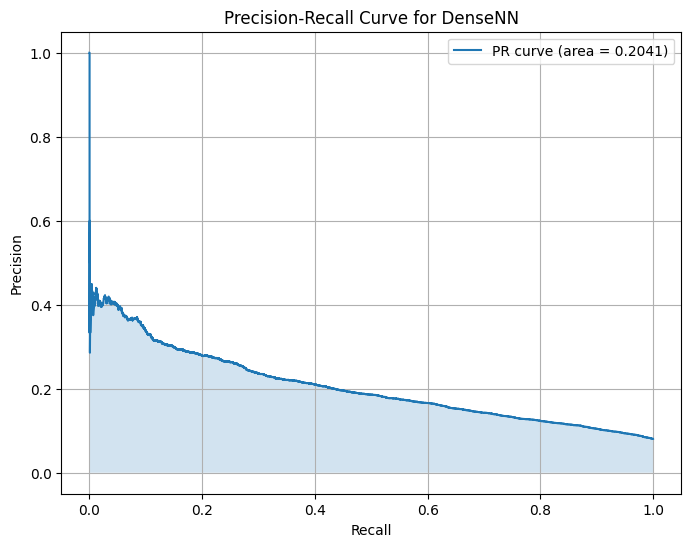

In [17]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_logits = model(X_test_tensor)                    # логиты (выход модели)
    y_proba = torch.sigmoid(y_logits).numpy().flatten()  # вероятности через sigmoid

# 2. Бинарные метки
y_pred = (y_proba >= 0.5).astype(int)

# 3. Метрики
roc = roc_auc_score(y_test, y_proba)
pr  = average_precision_score(y_test, y_proba)
print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC : {pr:.4f}")
print(classification_report(y_test, y_pred))

# 4. Визуализация PR-кривой
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (area = {pr:.4f})')
plt.fill_between(recall, precision, alpha=0.2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for DenseNN")
plt.legend()
plt.grid(True)
plt.show()

ROC-AUC: 0.7321 — приемлемый результат. Это означает, что модель в среднем различает классы лучше случайного (0.5), но хуже, чем CatBoost или XGBoost (у тебя было ~0.75).

PR-AUC: 0.2094 — низкий показатель. Это особенно важно при дисбалансе классов, как у тебя.

Recall (для класса 1): 1.00, но Precision: 0.08 — это означает, что модель помечает почти всё как класс 1, из-за чего:

она ловит все настоящие единицы (высокий recall),

но делает это ценой огромного количества ложных срабатываний (низкий precision),

поэтому f1-score = 0.15 — слабый.

Проблемы:
Модель не сбалансирована. Она просто предсказывает всё как класс 1 — признак переобучения на recall.

ROC-AUC "обманчиво" хороший, потому что метрика устойчива к дисбалансу, в отличие от PR-AUC и f1-score.

PR-кривая "рваная" и низкая — модель не имеет сильного confidence в предсказаниях.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [24]:
class ImprovedDenseNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # ← без Sigmoid
        )

    def forward(self, x):
        return self.model(x)

In [25]:
# Тензоры
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# pos_weight для BCEWithLogitsLoss
pos_weight = torch.tensor([len(y_train) / sum(y_train)], dtype=torch.float32)

# Модель, функция потерь и оптимизатор
model = ImprovedDenseNN(input_dim=X_train.shape[1])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Обучение
n_epochs = 100
model.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/100, Loss: 1.1920
Epoch 2/100, Loss: 1.1693
Epoch 3/100, Loss: 1.1660
Epoch 4/100, Loss: 1.1612
Epoch 5/100, Loss: 1.1585
Epoch 6/100, Loss: 1.1567
Epoch 7/100, Loss: 1.1539
Epoch 8/100, Loss: 1.1516
Epoch 9/100, Loss: 1.1497
Epoch 10/100, Loss: 1.1475
Epoch 11/100, Loss: 1.1455
Epoch 12/100, Loss: 1.1425
Epoch 13/100, Loss: 1.1405
Epoch 14/100, Loss: 1.1380
Epoch 15/100, Loss: 1.1359
Epoch 16/100, Loss: 1.1343
Epoch 17/100, Loss: 1.1327
Epoch 18/100, Loss: 1.1299
Epoch 19/100, Loss: 1.1280
Epoch 20/100, Loss: 1.1264
Epoch 21/100, Loss: 1.1228
Epoch 22/100, Loss: 1.1221
Epoch 23/100, Loss: 1.1202
Epoch 24/100, Loss: 1.1197
Epoch 25/100, Loss: 1.1148
Epoch 26/100, Loss: 1.1145
Epoch 27/100, Loss: 1.1121
Epoch 28/100, Loss: 1.1119
Epoch 29/100, Loss: 1.1103
Epoch 30/100, Loss: 1.1088
Epoch 31/100, Loss: 1.1059
Epoch 32/100, Loss: 1.1053
Epoch 33/100, Loss: 1.1023
Epoch 34/100, Loss: 1.1033
Epoch 35/100, Loss: 1.1020
Epoch 36/100, Loss: 1.1002
Epoch 37/100, Loss: 1.0970
Epoch 38/1

In [29]:
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor).squeeze()
    y_scores = torch.sigmoid(logits).numpy()  # ← вручную применяем Sigmoid
    y_pred = (y_scores >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)
report = classification_report(y_test, y_pred, output_dict=True)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")
print(pd.DataFrame(report).transpose())

ROC-AUC: 0.7290
PR-AUC : 0.2152
              precision    recall  f1-score       support
0              0.958877  0.661926  0.783199  56538.000000
1              0.149506  0.676737  0.244907   4965.000000
accuracy       0.663122  0.663122  0.663122      0.663122
macro avg      0.554191  0.669332  0.514053  61503.000000
weighted avg   0.893538  0.663122  0.739744  61503.000000
